In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TiffDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        Args:
            folder_path (str): Path to the folder containing TIFF images
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.folder_path = folder_path
        self.transform = transform
        
        # Get all TIFF files from the folder
        self.image_files = [f for f in os.listdir(folder_path) 
                          if f.lower().endswith(('.tiff', '.tif'))]
        
        if len(self.image_files) == 0:
            raise Exception(f"No TIFF files found in {folder_path}")
            
        print(f"Found {len(self.image_files)} TIFF images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        
        # Open the image using PIL (this ensures it's a PIL Image)
        image = Image.open(img_path)
        
        # If the image is grayscale, convert it to RGB by duplicating the single channel
        if image.mode != 'RGB':
            image = image.convert('RGB')  # Convert grayscale to RGB

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)  # Apply transforms directly on PIL Image
            
        return image, self.image_files[idx]

# Example usage:
def main():
    # Define the folder path
    folder_path = "C:/Users/Jayesh/OneDrive/Documents/Scratch/dataset/Dataset_01/M175124932LR"
    
    # Define transformations if needed
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to standard size
        transforms.ToTensor(),          # Convert image to Tensor (channel first format)
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # RGB normalization
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    dataset = TiffDataset(folder_path, transform=transform)
    
    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    # Example: Print first batch
    for images, filenames in dataloader:
        print("Batch shape:", images.shape)
        print("Filenames:", filenames)
        break

if __name__ == "__main__":
    main()


Found 19737 TIFF images
Batch shape: torch.Size([4, 3, 224, 224])
Filenames: ('tile_378_24.tiff', 'tile_25_38.tiff', 'tile_48_29.tiff', 'tile_371_39.tiff')


Using device: cpu


c:\Users\Jayesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jayesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: Image data of dtype object cannot be converted to float

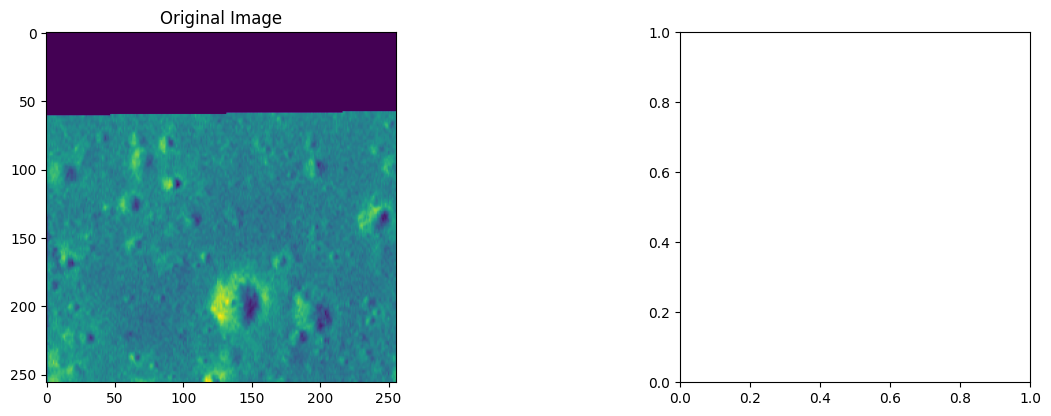

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import os
import wandb
import numpy as np
import torch.nn.functional as F
import cv2

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class ImageAnalysisModel:
    def __init__(self, model_path=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Initialize model
        self.model = self.setup_model()
        
        # Load pre-trained weights if provided
        if model_path and os.path.exists(model_path):
            self.load_model(model_path)
            
        # Initialize wandb for tracking
        wandb.init(project="image-analysis", name="model-inference")

    def setup_model(self):
        """Setup the model architecture"""
        model = models.resnet50(pretrained=True)
        model.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1000)  # Adjust output size as needed
        )
        return model.to(self.device)

    def load_model(self, model_path):
        """Load pre-trained weights"""
        try:
            self.model.load_state_dict(torch.load(model_path))
            print(f"Model loaded successfully from {model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")

    def preprocess_image(self, image_path):
        """Preprocess image for model input with augmentation"""
        try:
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Data Augmentation
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(20),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])
            
            return transform(image).unsqueeze(0)
        except Exception as e:
            print(f"Error preprocessing image: {e}")
            return None

    def analyze_image(self, image_path, save_visualization=True):
        """Analyze an image and return results"""
        # Preprocess image
        image_tensor = self.preprocess_image(image_path)
        if image_tensor is None:
            return None

        # Move to device
        image_tensor = image_tensor.to(self.device)

        # Model inference
        self.model.eval()
        with torch.no_grad():
            features = self.model(image_tensor)
            
        # Process results
        results = self.process_features(features)
        
        # Save visualization if requested
        if save_visualization:
            self.visualize_results(image_path, results)
            
        return results

    def process_features(self, features):
        """Process model output features (optional post-processing)"""
        # You could use softmax to get probabilities or perform further processing
        probs = F.softmax(features, dim=1)  # Convert features to probabilities
        return probs

    def visualize_results(self, image_path, results):
        """Create and save visualizations (including Grad-CAM)"""
        # Original image
        image = Image.open(image_path)
        
        plt.figure(figsize=(15, 10))
        
        # Plot original image
        plt.subplot(2, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        
        # Plot Grad-CAM visualization
        plt.subplot(2, 2, 2)
        grad_cam_map = self.generate_grad_cam(image_path)
        plt.imshow(grad_cam_map, cmap='jet', alpha=0.5)
        plt.title("Grad-CAM Visualization")
        
        # Save plot
        visualization_path = 'visualization.png'  # Changed file name to 'visualization.png'
        plt.savefig(visualization_path)
        
        # Log to wandb with the new filename
        wandb.log({
            "original_image": wandb.Image(image),
            "grad_cam_map": wandb.Image(visualization_path)  # Updated to use new name
        })

    def generate_grad_cam(self, image_path):
        """Generate Grad-CAM visualization for the last convolutional layer"""
        # Preprocess the image
        image_tensor = self.preprocess_image(image_path).to(self.device)
        image_tensor.requires_grad = True

        # Placeholder to store feature maps and gradients
        activations = []
        gradients = []

        def forward_hook(module, input, output):
            activations.append(output)

        def backward_hook(module, grad_input, grad_output):
            gradients.append(grad_output[0])

    # Register hooks to the last convolutional layer
            target_layer = self.model.layer4[2].conv3  # Last convolutional layer in ResNet-50
            forward_handle = target_layer.register_forward_hook(forward_hook)
            backward_handle = target_layer.register_backward_hook(backward_hook)

            # Forward pass
            self.model.eval()
            output = self.model(image_tensor)

            # Get the class index with the highest score
            class_idx = output.argmax(dim=1).item()

            # Backward pass (compute gradients)
            self.model.zero_grad()
            output[0, class_idx].backward()

            # Remove hooks
            forward_handle.remove()
            backward_handle.remove()

            # Get the stored activations and gradients
            activations = activations[0].squeeze().cpu().detach().numpy()
            gradients = gradients[0].squeeze().cpu().detach().numpy()

            # Compute channel-wise weights using global average pooling
            weights = np.mean(gradients, axis=(1, 2))

            # Generate Grad-CAM by weighting the activation maps
            grad_cam_map = np.zeros(activations.shape[1:], dtype=np.float32)
            for i, w in enumerate(weights):
                grad_cam_map += w * activations[i]

            # Apply ReLU to remove negative values
            grad_cam_map = np.maximum(grad_cam_map, 0)

            # Normalize the heatmap
            grad_cam_map = grad_cam_map - np.min(grad_cam_map)
            grad_cam_map = grad_cam_map / np.max(grad_cam_map)

            # Resize the Grad-CAM map to the input image size
            grad_cam_map = Image.fromarray((grad_cam_map * 255).astype(np.uint8)).resize(
                (224, 224), Image.BICUBIC
            )
            grad_cam_map = np.array(grad_cam_map) / 255.0  # Normalize to range [0, 1]

            return grad_cam_map



# Example usage
def main():
    # Initialize model
    model_path = "Model/visualization_model.pth"  # Replace with your model path
    analyzer = ImageAnalysisModel(model_path)
    
    # Analyze single image
    image_path = "C:/Users/Jayesh/OneDrive/Documents/Scratch/dataset/Dataset_01/M175124932LR/tile_0_0.tiff"
    results = analyzer.analyze_image(image_path)
    
    # Batch processing
    def process_folder(folder_path):
        for image_file in os.listdir(folder_path):
            if image_file.endswith(('.tiff', '.tif')):
                image_path = os.path.join(folder_path, image_file)
                print(f"Processing: {image_path}")
                analyzer.analyze_image(image_path)

    # Process entire folder
    folder_path = "C:/Users/Jayesh/OneDrive/Documents/Scratch/dataset/Dataset_01/M175124932LR"
    process_folder(folder_path)

if __name__ == "__main__":
    main()
